In [101]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Reshape
import ast
from sklearn.model_selection import train_test_split
import numpy as np

In [102]:
pd.set_option('display.max_columns', None)  # Para mostrar todas as colunas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)  # Para permitir que as colunas sejam exibidas sem corte

In [103]:
df = pd.read_csv(r'C:\Users\vieir\Mestrado\TESE\pipeline\resultados\df_all_emoticon_seq_list_filtrado1_com_virgula.csv')


In [104]:
# Converter strings para listas de dicionários, se necessário
if df["emotion_sequence"].apply(type).eq(str).any():
    df["emotion_sequence"] = df["emotion_sequence"].apply(ast.literal_eval)

if df["score_sequence"].apply(type).eq(str).any():
    df["score_sequence"] = df["score_sequence"].apply(ast.literal_eval)


In [105]:
def corrigir_lista_em_string(texto):
    texto = texto.strip().replace('[', '').replace(']', '')  # tira colchetes
    texto = ','.join(texto.split())  # insere vírgula entre números
    return ast.literal_eval(f"[{texto}]")

df["padded_sequence"] = df["padded_sequence"].apply(corrigir_lista_em_string)

In [106]:
df.head(1)

,tweet_id,text,language,type,bookmark_count,favorite_count,retweet_count,reply_count,view_count,created_at,client,hashtags,urls,media_type,media_urls,usuario_id,nome,n tweets,n seguidores,categoria,Factual Reporting,usuario,classification,emoji_count,text_clean,text_clean_sw,sentiment_textblob,sentiment_vader,sentiment_transformers,emotion_recognition,emotion_sequence,padded_sequence,score_sequence
0,'1861174452215529687',How do you express gratitude for one’s safety when the perils posed by the American police state grow more treacherous by the day?\nhttps://t.co/5O7Kc79dzn,en,Tweet,1.0,3.0,2.0,0.0,123.0,2024-11-25 22:25:43,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",NaN,https://activistpost.com/2024/11/divide-and-conquer-political-riptides-threaten-to-overwhelm-the-nation.html,NaN,NaN,ActivistPost,Activist Post,1000.0,41070.0,Pseudoscience,low,ActivistPost,fake news,0,How do you express gratitude for one’s safety when the perils posed by the American police state grow more treacherous by the day?,express gratitude one’s safety perils posed American police state grow treacherous day?,positive,positive,negative,"[{'subsentence': 'How do you express gratitude', 'emotion': 'neutral', 'score': 0.7985137104988098}, {'subsentence': 'one’s safety', 'emotion': 'neutral', 'score': 0.6995041966438293}, {'subsentence': 'the perils posed by the American police state grow more treacherous by the day', 'emotion': 'fear', 'score': 0.9794434309005737}]","[5, 5, 3]","[5, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.7985137104988098, 0.6995041966438293, 0.9794434309005737]"


In [107]:
MAX_LEN = len(df["padded_sequence"].iloc[0])
MAX_LEN

100

In [108]:
def pad_scores(scores):
    # Completa com zeros até MAX_LEN
    return scores + [0.0] * (MAX_LEN - len(scores))

In [109]:
df["score_sequence_padded"] = df["score_sequence"].apply(pad_scores)

In [110]:
df['classification'].unique()

array(['fake news', 'reliable news'], dtype=object)

In [111]:
# Mapear categoria para classe binária
label_map = {"fake news": 1, "reliable news": 0}
df["label"] = df["classification"].map(label_map)

In [112]:
# Gerar coluna de estratificação combinada
df["estrato"] = df["label"].astype(str) + "_" + df["categoria"]

In [113]:
df.head(2)

,tweet_id,text,language,type,bookmark_count,favorite_count,retweet_count,reply_count,view_count,created_at,client,hashtags,urls,media_type,media_urls,usuario_id,nome,n tweets,n seguidores,categoria,Factual Reporting,usuario,classification,emoji_count,text_clean,text_clean_sw,sentiment_textblob,sentiment_vader,sentiment_transformers,emotion_recognition,emotion_sequence,padded_sequence,score_sequence,score_sequence_padded,label,estrato
0,'1861174452215529687',How do you express gratitude for one’s safety when the perils posed by the American police state grow more treacherous by the day?\nhttps://t.co/5O7Kc79dzn,en,Tweet,1.0,3.0,2.0,0.0,123.0,2024-11-25 22:25:43,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",NaN,https://activistpost.com/2024/11/divide-and-conquer-political-riptides-threaten-to-overwhelm-the-nation.html,NaN,NaN,ActivistPost,Activist Post,1000.0,41070.0,Pseudoscience,low,ActivistPost,fake news,0,How do you express gratitude for one’s safety when the perils posed by the American police state grow more treacherous by the day?,express gratitude one’s safety perils posed American police state grow treacherous day?,positive,positive,negative,"[{'subsentence': 'How do you express gratitude', 'emotion': 'neutral', 'score': 0.7985137104988098}, {'subsentence': 'one’s safety', 'emotion': 'neutral', 'score': 0.6995041966438293}, {'subsentence': 'the perils posed by the American police state grow more treacherous by the day', 'emotion': 'fear', 'score': 0.9794434309005737}]","[5, 5, 3]","[5, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.7985137104988098, 0.6995041966438293, 0.9794434309005737]","[0.7985137104988098, 0.6995041966438293, 0.9794434309005737, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1,1_Pseudoscience
1,'1861069708536991847',"Scientists have uncovered a new chemical compound lurking in U.S. drinking water, potentially exposing one in five Americans to an unidentified health risk.\nhttps://t.co/kbL1Hm2kBX",en,Tweet,1.0,2.0,3.0,0.0,176.0,2024-11-25 15:29:30,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",NaN,https://naturalblaze.com/2024/11/researchers-find-unknown-chemical-in-drinking-water-posing-potential-human-health-concern.html,NaN,NaN,ActivistPost,Activist Post,1000.0,41070.0,Pseudoscience,low,ActivistPost,fake news,0,"Scientists have uncovered a new chemical compound lurking in U.S. drinking water, potentially exposing one in five Americans to an unidentified health risk.","Scientists uncovered new chemical compound lurking U.S. drinking water, potentially exposing one five Americans unidentified health risk.",positive,negative,negative,"[{'subsentence': 'Scientists have uncovered a new chemical compound lurking in U', 'emotion': 'disgust', 'score': 0.5785960555076599}, {'subsentence': 'S', 'emotion': 'neutral', 'score': 0.5676681399345398}, {'subsentence': 'drinking water', 'emotion': 'neutral', 'score': 0.6897717714309692}, {'subsentence': 'potentially exposing one in five Americans to an unidentified health risk', 'emotion': 'fear', 'score': 0.5272312164306641}]","[2, 5, 5, 3]","[2, 5, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [114]:
# Transformar os dados em arrays
X_ids = np.array(df["padded_sequence"].to_list())
X_scores = np.array(df["score_sequence_padded"].to_list())
y_labels = df["label"].values  

In [115]:
def separar_treino_validacao_teste(X_ids, X_scores, y, estrato, test_size=0.2, val_size=0.2, random_state=42):
    """
    Divide os dados em treino, validação e teste com estratificação por grupo combinado.
    - test_size: proporção final de teste (ex: 0.2 → 20%)
    - val_size : proporção da validação sobre o conjunto de treino+validação
    """

    # Passo 1 — separa teste
    X_ids_temp, X_ids_test, \
    X_scores_temp, X_scores_test, \
    y_temp, y_test, \
    estrato_temp, estrato_test = train_test_split(
        X_ids, X_scores, y, estrato,
        test_size=test_size,
        stratify=estrato,
        random_state=random_state
    )

    # Passo 2 — separa validação do que sobrou
    val_rel_size = val_size / (1 - test_size)  # ex: 0.2 / 0.8 = 0.25

    X_ids_train, X_ids_val, \
    X_scores_train, X_scores_val, \
    y_train, y_val = train_test_split(
        X_ids_temp, X_scores_temp, y_temp,
        test_size=val_rel_size,
        stratify=estrato_temp,
        random_state=random_state
    )

    return (X_ids_train, X_scores_train, y_train), \
           (X_ids_val, X_scores_val, y_val), \
           (X_ids_test, X_scores_test, y_test)

In [116]:
estrato = df["estrato"]

# Separação
(train_ids, train_scores, y_train), \
(val_ids, val_scores, y_val), \
(test_ids, test_scores, y_test) = separar_treino_validacao_teste(
    X_ids, X_scores, y_labels, estrato, test_size=0.2, val_size=0.2
)

print("🔹 Treino:", train_ids.shape)
print("🔹 Validação:", val_ids.shape)
print("🔹 Teste:", test_ids.shape)

🔹 Treino: (38223, 100)
🔹 Validação: (12742, 100)
🔹 Teste: (12742, 100)


In [133]:
# Configuracoes
num_emotions = 8       # número de categorias emocionais
embedding_dim = 16
lstm_units = 64
max_len = train_ids.shape[1]

# Entrada 1: IDs das emoções
input_ids = Input(shape=(max_len,), name='emotion_ids_input')
# x_ids = Embedding(input_dim=num_emotions, output_dim=embedding_dim, mask_zero=True)(input_ids)
x_ids = Embedding(input_dim=num_emotions, output_dim=embedding_dim)(input_ids)

# Entrada 2: scores de confiança
input_scores = Input(shape=(max_len,), name='confidence_scores_input')
x_scores = Reshape((max_len, 1))(input_scores)

# Fusão
x = Concatenate(axis=-1)([x_ids, x_scores])
x = LSTM(lstm_units)(x)
output = Dense(1, activation='sigmoid')(x)

# Modelo
model = Model(inputs=[input_ids, input_scores], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ emotion_ids_input   │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ confidence_scores_… │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 100, 16)   │        128 │ emotion_ids_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 100, 1)    │          0 │ confidence_score… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 100, 17)   │          0 │ embedding_8[0][0… │
│ (Concatenate)       │                   │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 64)        │     20,992 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ lstm_6[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,185 (82.75 KB)

 Trainable params: 21,185 (82.75 KB)

 Non-trainable params: 0 (0.00 B)

In [118]:
train_scores = train_scores.astype('float32')
val_scores = val_scores.astype('float32')
test_scores = test_scores.astype('float32')

train_ids = train_ids.astype('int32')
val_ids = val_ids.astype('int32')
test_ids = test_ids.astype('int32')

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')


In [119]:
print("train_scores dtype:", train_scores.dtype)
print("train_ids dtype:", train_ids.dtype)
print("y_train dtype:", y_train.dtype)


train_scores dtype: float32
train_ids dtype: int32
y_train dtype: float32


In [134]:
history = model.fit(
    x={'emotion_ids_input': train_ids, 'confidence_scores_input': train_scores},
    y=y_train,
    batch_size=64,
    epochs=10,
    validation_data=(
        {'emotion_ids_input': val_ids, 'confidence_scores_input': val_scores},
        y_val
    )
)

Epoch 1/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.5702 - loss: 0.6830 - val_accuracy: 0.5760 - val_loss: 0.6822
Epoch 2/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.5753 - loss: 0.6818 - val_accuracy: 0.5760 - val_loss: 0.6816
Epoch 3/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.5714 - loss: 0.6833 - val_accuracy: 0.5760 - val_loss: 0.6816
Epoch 4/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.5805 - loss: 0.6803 - val_accuracy: 0.5760 - val_loss: 0.6816
Epoch 5/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.5731 - loss: 0.6825 - val_accuracy: 0.5760 - val_loss: 0.6816
Epoch 6/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.5748 - loss: 0.6821 - val_accuracy: 0.5760 - val_loss: 0.6816
Epoch 7/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.5733 - loss: 0.6826 - val_accuracy: 0.5760 - val_loss: 0.6816
Epoch 8/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.5774 - loss: 0.6813 - 

In [121]:
import numpy as np

np.savez_compressed(
    'dados_emocoes_divididos.npz',
    train_ids=train_ids,
    train_scores=train_scores,
    y_train=y_train,
    val_ids=val_ids,
    val_scores=val_scores,
    y_val=y_val,
    test_ids=test_ids,
    test_scores=test_scores,
    y_test=y_test
)


In [206]:
# Carregar os dados
dados = np.load('dados_emocoes_divididos.npz')

train_ids = dados['train_ids']
train_scores = dados['train_scores']
y_train = dados['y_train']
val_ids = dados['val_ids']
val_scores = dados['val_scores']
y_val = dados['y_val']
test_ids = dados['test_ids']
test_scores = dados['test_scores']
y_test = dados['y_test']

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# EarlyStopping configurado
early_stop = EarlyStopping(
    monitor='val_loss',       # ou 'val_accuracy'
    patience=3,               # espera 3 épocas sem melhora
    restore_best_weights=True
)
# Callback para salvar o melhor modelo com base em val_loss
checkpoint = ModelCheckpoint(
    filepath='melhor_modelo_confidence_scores.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False  # salva o modelo inteiro
)
# Treinamento com callback
history = model.fit(
    x={'emotion_ids_input': train_ids, 'confidence_scores_input': train_scores},
    y=y_train,
    batch_size=64,
    epochs=100,
    validation_data=(
        {'emotion_ids_input': val_ids, 'confidence_scores_input': val_scores},
        y_val
    ),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.5729 - loss: 0.6826 - val_accuracy: 0.5760 - val_loss: 0.6816
Epoch 2/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.5759 - loss: 0.6818 - val_accuracy: 0.5760 - val_loss: 0.6816
Epoch 3/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5796 - loss: 0.6805 - val_accuracy: 0.5760 - val_loss: 0.6816
Epoch 4/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5763 - loss: 0.6816 - val_accuracy: 0.5760 - val_loss: 0.6817
Epoch 5/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5740 - loss: 0.6822 - val_accuracy: 0.5760 - val_loss: 0.6818
Epoch 6/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5738 - loss: 0.6824 - val_accuracy: 0.5760 - val_loss: 0.6816
Epoch 7/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5759 - loss: 0.6817 - val_accuracy: 0.5760 - val_loss: 0.6816
Epoch 8/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 

In [ ]:
import pickle

# Salvar histórico após o model.fit()
with open('historico_treinamento_confidence_scores_B64.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [125]:
# Parâmetros
num_emotions = np.max(train_ids) + 1  # pega o maior ID + 1
embedding_dim = 16
lstm_units = 64
max_len = train_ids.shape[1]  # tamanho das sequências já padded

# Entrada
input_ids = Input(shape=(max_len,), name='emotion_ids_input')

# Embedding com mask_zero ativado
x = Embedding(input_dim=num_emotions, output_dim=embedding_dim, mask_zero=True)(input_ids)

# LSTM
x = LSTM(lstm_units)(x)

# Saída binária (fake = 1, real = 0)
output = Dense(1, activation='sigmoid')(x)

# Modelo final
model_ids_only = Model(inputs=input_ids, outputs=output)
model_ids_only.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumo
model_ids_only.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ emotion_ids_input   │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 100, 16)   │        128 │ emotion_ids_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 100)       │          0 │ emotion_ids_inpu… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │     20,736 │ embedding_7[0][0… │
│                     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,929 (81.75 KB)

 Trainable params: 20,929 (81.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callback para parada antecipada
early_stop = EarlyStopping(
    monitor='val_accuracy',         # ou 'val_accuracy', se preferir
    patience=3,                 # espera 3 épocas sem melhora
    restore_best_weights=True  # recupera os melhores pesos
)
# Callback para salvar o melhor modelo com base em val_loss
checkpoint = ModelCheckpoint(
    filepath='melhor_modelo_B64.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False  # salva o modelo inteiro
)
# Treinamento
history = model_ids_only.fit(
    x=train_ids,
    y=y_train,
    batch_size=64,
    epochs=100,
    validation_data=(val_ids, y_val),
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.6327 - loss: 0.6370 - val_accuracy: 0.6548 - val_loss: 0.6218
Epoch 2/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.6560 - loss: 0.6205 - val_accuracy: 0.6555 - val_loss: 0.6206
Epoch 3/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.6578 - loss: 0.6180 - val_accuracy: 0.6558 - val_loss: 0.6175
Epoch 4/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.6628 - loss: 0.6161 - val_accuracy: 0.6564 - val_loss: 0.6180
Epoch 5/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 460s 383ms/step - accuracy: 0.6624 - loss: 0.6137 - val_accuracy: 0.6607 - val_loss: 0.6145
Epoch 6/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 998s 834ms/step - accuracy: 0.6661 - loss: 0.6129 - val_accuracy: 0.6614 - val_loss: 0.6144
Epoch 7/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 1032s 824ms/step - accuracy: 0.6617 - loss: 0.6121 - val_accuracy: 0.6609 - val_loss: 0.6151
Epoch 8/100
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - acc

In [127]:
results = model_ids_only.evaluate(test_ids, y_test)
print(f"🔍 Test Loss: {results[0]:.4f} — Test Accuracy: {results[1]:.4f}")


399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6799 - loss: 0.6024
🔍 Test Loss: 0.6108 — Test Accuracy: 0.6684


In [128]:
import pickle

# Salvar histórico após o model.fit()
with open('historico_treinamento.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [130]:
from tensorflow.keras.models import load_model

path_modelo_com_scores= 'melhor_modelo_confidence_scores.keras'
path_modelo_sem_scores= 'melhor_modelo.keras'

# Carregar o modelos
modelo_com_scores = load_model(path_modelo_com_scores)
modelo_sem_scores = load_model(path_modelo_sem_scores)

In [131]:
from sklearn.metrics import classification_report

val_pred_probs = modelo_com_scores.predict({
    'emotion_ids_input': val_ids,
    'confidence_scores_input': val_scores
})
val_pred = (val_pred_probs > 0.5).astype(int)

print("🔍 Relatório de Classificação - Validação")
print(classification_report(y_val, val_pred, target_names=["real", "fake"]))

# === TESTE ===
test_pred_probs = modelo_com_scores.predict({
    'emotion_ids_input': test_ids,
    'confidence_scores_input': test_scores
})
test_pred = (test_pred_probs > 0.5).astype(int)

print("🔍 Relatório de Classificação - Teste")
print(classification_report(y_test, test_pred, target_names=["real", "fake"]))

399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
🔍 Relatório de Classificação - Validação
              precision    recall  f1-score   support

        real       0.58      1.00      0.73      7339
        fake       0.00      0.00      0.00      5403

    accuracy                           0.58     12742
   macro avg       0.29      0.50      0.37     12742
weighted avg       0.33      0.58      0.42     12742

  9/399 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step 

c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
🔍 Relatório de Classificação - Teste
              precision    recall  f1-score   support

        real       0.58      1.00      0.73      7339
        fake       0.00      0.00      0.00      5403

    accuracy                           0.58     12742
   macro avg       0.29      0.50      0.37     12742
weighted avg       0.33      0.58      0.42     12742



c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [132]:
val_pred_probs = modelo_sem_scores.predict(val_ids)
print("🔍 Relatório de Classificação - Validação")
print(classification_report(y_val, val_pred_probs, target_names=["real", "fake"]))

test_pred_probs = modelo_sem_scores.predict(test_ids)
print("🔍 Relatório de Classificação - Teste")
print(classification_report(y_test, test_pred_probs, target_names=["real", "fake"]))

399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
🔍 Relatório de Classificação - Validação


ValueError: Classification metrics can't handle a mix of binary and continuous targets

### treino LSTM

In [135]:
import numpy as np
import itertools
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report


In [162]:
# Hiperparâmetros
unidades = [32, 64, 128, 256]
batches = [32, 64, 128, 256]
embeddings = [16, 32]
learning_rates = [0.0025, 0.005, 0.01]
epochs = 100

num_emotions = 8
max_len = train_ids.shape[1]

resultados = []

for lstm_units, batch_size, embedding_dim, lr in itertools.product(unidades, batches, embeddings, learning_rates):
    print(f"🔄 LSTM={lstm_units} | Batch={batch_size} | Embedding={embedding_dim} | LR={lr}")

    input_ids = Input(shape=(max_len,), name='emotion_ids_input')
    x_ids = Embedding(input_dim=num_emotions, output_dim=embedding_dim)(input_ids)

    input_scores = Input(shape=(max_len,), name='confidence_scores_input')
    x_scores = Reshape((max_len, 1))(input_scores)

    x = Concatenate(axis=-1)([x_ids, x_scores])
    x = LSTM(lstm_units)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_ids, input_scores], outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    nome_modelo = f"modelo_lstm{lstm_units}_batch{batch_size}_emb{embedding_dim}_lr{str(lr).replace('.', '')}.keras"

    checkpoint = ModelCheckpoint(
        filepath=nome_modelo,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x={'emotion_ids_input': train_ids, 'confidence_scores_input': train_scores},
        y=y_train,
        batch_size=batch_size,
        epochs=100,
        validation_data=(
            {'emotion_ids_input': val_ids, 'confidence_scores_input': val_scores},
            y_val
        ),
        verbose=0,
        callbacks=[early_stop, checkpoint]
    )

    y_pred_probs = model.predict({'emotion_ids_input': val_ids, 'confidence_scores_input': val_scores})
    y_pred = (y_pred_probs > 0.5).astype(int)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    acc = report['accuracy']
    f1_fake = report.get('1', {}).get('f1-score', 0.0)

    print(f"💾 Modelo salvo: {nome_modelo}")
    print(f"✅ Resultado: Accuracy={acc:.4f} | F1-Fake={f1_fake:.4f}")

    resultados.append({
        'lstm_units': lstm_units,
        'batch_size': batch_size,
        'embedding_dim': embedding_dim,
        'learning_rate': lr,
        'accuracy': acc,
        'f1_fake': f1_fake,
        'model_file': nome_modelo
    })

# Salvar os resultados
with open('resultados_gridsearch2.pkl', 'wb') as f:
    pickle.dump(resultados, f)

# Mostrar os 5 melhores
resultados.sort(key=lambda x: x['f1_fake'], reverse=True)
print("\\n🏆 Top 5 configurações por F1-Fake:")
for r in resultados[:5]:
    print(f"📂 {r['model_file']} | F1-Fake={r['f1_fake']:.4f} | Accuracy={r['accuracy']:.4f}")

🔄 LSTM=32 | Batch=32 | Embedding=16 | LR=0.0025

Epoch 1: val_loss improved from inf to 0.68161, saving model to modelo_lstm32_batch32_emb16_lr00025.keras

Epoch 2: val_loss improved from 0.68161 to 0.68156, saving model to modelo_lstm32_batch32_emb16_lr00025.keras

Epoch 3: val_loss did not improve from 0.68156

Epoch 4: val_loss did not improve from 0.68156

Epoch 5: val_loss did not improve from 0.68156

Epoch 6: val_loss did not improve from 0.68156

Epoch 7: val_loss did not improve from 0.68156
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
💾 Modelo salvo: modelo_lstm32_batch32_emb16_lr00025.keras
✅ Resultado: Accuracy=0.5760 | F1-Fake=0.0000
🔄 LSTM=32 | Batch=32 | Embedding=16 | LR=0.005

Epoch 1: val_loss improved from inf to 0.68196, saving model to modelo_lstm32_batch32_emb16_lr0005.keras

Epoch 2: val_loss improved from 0.68196 to 0.68157, saving model to modelo_lstm32_batch32_emb16_lr0005.keras

Epoch 3: val_loss did not improve from 0.68157

Epoch 4: val_loss did not improve fro

In [217]:
# Hiperparâmetros
unidades = [128]
batches = [32]
embeddings = [32]
learning_rates = [0.001]
epochs = 100

num_emotions = 8
max_len = train_ids.shape[1]

resultados = []


for lstm_units, batch_size, embedding_dim, lr in itertools.product(unidades, batches, embeddings, learning_rates):
    print(f"🔄 LSTM={lstm_units} | Batch={batch_size} | Embedding={embedding_dim} | LR={lr}")

    input_ids = Input(shape=(max_len,), name='emotion_ids_input')
    x = Embedding(input_dim=num_emotions, output_dim=embedding_dim, mask_zero=True)(input_ids)
    x = LSTM(lstm_units)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    nome_modelo = f"modelo_IDS_lstm{lstm_units}_batch{batch_size}_emb{embedding_dim}_lr{str(lr).replace('.', '')}.keras"

    checkpoint = ModelCheckpoint(
        filepath=nome_modelo,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=train_ids,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_ids, y_val),
        verbose=0,
        callbacks=[early_stop, checkpoint]
    )

    y_pred_probs = model.predict(val_ids)
    y_pred = (y_pred_probs > 0.5).astype(int)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    acc = report['accuracy']
    f1_fake = report.get('1', {}).get('f1-score', 0.0)

    print(f"💾 Modelo salvo: {nome_modelo}")
    print(f"✅ Resultado: Accuracy={acc:.4f} | F1-Fake={f1_fake:.4f}")

    resultados.append({
        'lstm_units': lstm_units,
        'batch_size': batch_size,
        'embedding_dim': embedding_dim,
        'learning_rate': lr,
        'accuracy': acc,
        'f1_fake': f1_fake,
        'model_file': nome_modelo
    })

# Salvar os resultados
with open('resultados_gridsearch_IDS2.pkl', 'wb') as f:
    pickle.dump(resultados, f)

# Mostrar os 5 melhores
resultados.sort(key=lambda x: x['f1_fake'], reverse=True)
print("\n -------------------------------------------------------------------------------------------------------------- \n")
print("\\n🏆 Top 5 configurações por F1-Fake:")
for r in resultados[:5]:
    print(f"📂 {r['model_file']} | F1-Fake={r['f1_fake']:.4f} | Accuracy={r['accuracy']:.4f}")

🔄 LSTM=128 | Batch=32 | Embedding=32 | LR=0.001
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step
💾 Modelo salvo: modelo_IDS_lstm128_batch32_emb32_lr0001.keras
✅ Resultado: Accuracy=0.6675 | F1-Fake=0.0000

 -------------------------------------------------------------------------------------------------------------- 

\n🏆 Top 5 configurações por F1-Fake:
📂 modelo_IDS_lstm128_batch32_emb32_lr0001.keras | F1-Fake=0.0000 | Accuracy=0.6675


In [223]:
# Hiperparâmetros
unidades = [32]
batches = [64]
embeddings = [32]
learning_rates = [0.01]
epochs = 100

num_emotions = 8
max_len = train_ids.shape[1]

resultados = []


for lstm_units, batch_size, embedding_dim, lr in itertools.product(unidades, batches, embeddings, learning_rates):
    print(f"🔄 LSTM={lstm_units} | Batch={batch_size} | Embedding={embedding_dim} | LR={lr}")

    input_ids = Input(shape=(max_len,), name='emotion_ids_input')
    x = Embedding(input_dim=num_emotions, output_dim=embedding_dim, mask_zero=True)(input_ids)
    x = LSTM(lstm_units)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    nome_modelo = f"modelo_IDS_lstm{lstm_units}_batch{batch_size}_emb{embedding_dim}_lr{str(lr).replace('.', '')}.keras"

    checkpoint = ModelCheckpoint(
        filepath=nome_modelo,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=train_ids,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_ids, y_val),
        verbose=0,
        callbacks=[early_stop, checkpoint]
    )

    y_pred_probs = model.predict(val_ids)
    y_pred = (y_pred_probs > 0.5).astype(int)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    acc = report['accuracy']
    f1_fake = report.get('1', {}).get('f1-score', 0.0)

    print(f"💾 Modelo salvo: {nome_modelo}")
    print(f"✅ Resultado: Accuracy={acc:.4f} | F1-Fake={f1_fake:.4f}")

    resultados.append({
        'lstm_units': lstm_units,
        'batch_size': batch_size,
        'embedding_dim': embedding_dim,
        'learning_rate': lr,
        'accuracy': acc,
        'f1_fake': f1_fake,
        'model_file': nome_modelo
    })

# Salvar os resultados
with open('resultados_gridsearch_IDS2.pkl', 'wb') as f:
    pickle.dump(resultados, f)

# Mostrar os 5 melhores
resultados.sort(key=lambda x: x['f1_fake'], reverse=True)
print("\n -------------------------------------------------------------------------------------------------------------- \n")
print("\\n🏆 Top 5 configurações por F1-Fake:")
for r in resultados[:5]:
    print(f"📂 {r['model_file']} | F1-Fake={r['f1_fake']:.4f} | Accuracy={r['accuracy']:.4f}")

🔄 LSTM=32 | Batch=64 | Embedding=32 | LR=0.01
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
💾 Modelo salvo: modelo_IDS_lstm32_batch64_emb32_lr001.keras
✅ Resultado: Accuracy=0.6633 | F1-Fake=0.0000

 -------------------------------------------------------------------------------------------------------------- 

\n🏆 Top 5 configurações por F1-Fake:
📂 modelo_IDS_lstm32_batch64_emb32_lr001.keras | F1-Fake=0.0000 | Accuracy=0.6633


In [224]:
# Hiperparâmetros
unidades = [128]
batches = [32]
embeddings = [32]
learning_rates = [0.01]
epochs = 100

num_emotions = 8
max_len = train_ids.shape[1]

resultados = []


for lstm_units, batch_size, embedding_dim, lr in itertools.product(unidades, batches, embeddings, learning_rates):
    print(f"🔄 LSTM={lstm_units} | Batch={batch_size} | Embedding={embedding_dim} | LR={lr}")

    input_ids = Input(shape=(max_len,), name='emotion_ids_input')
    x = Embedding(input_dim=num_emotions, output_dim=embedding_dim, mask_zero=True)(input_ids)
    x = LSTM(lstm_units)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    nome_modelo = f"modelo_IDS_lstm{lstm_units}_batch{batch_size}_emb{embedding_dim}_lr{str(lr).replace('.', '')}.keras"

    checkpoint = ModelCheckpoint(
        filepath=nome_modelo,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=train_ids,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_ids, y_val),
        verbose=0,
        callbacks=[early_stop, checkpoint]
    )

    y_pred_probs = model.predict(val_ids)
    y_pred = (y_pred_probs > 0.5).astype(int)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    acc = report['accuracy']
    f1_fake = report.get('1', {}).get('f1-score', 0.0)

    print(f"💾 Modelo salvo: {nome_modelo}")
    print(f"✅ Resultado: Accuracy={acc:.4f} | F1-Fake={f1_fake:.4f}")

    resultados.append({
        'lstm_units': lstm_units,
        'batch_size': batch_size,
        'embedding_dim': embedding_dim,
        'learning_rate': lr,
        'accuracy': acc,
        'f1_fake': f1_fake,
        'model_file': nome_modelo
    })

# Salvar os resultados
with open('resultados_gridsearch_IDS2.pkl', 'wb') as f:
    pickle.dump(resultados, f)

# Mostrar os 5 melhores
resultados.sort(key=lambda x: x['f1_fake'], reverse=True)
print("\n -------------------------------------------------------------------------------------------------------------- \n")
print("\\n🏆 Top 5 configurações por F1-Fake:")
for r in resultados[:5]:
    print(f"📂 {r['model_file']} | F1-Fake={r['f1_fake']:.4f} | Accuracy={r['accuracy']:.4f}")

🔄 LSTM=128 | Batch=32 | Embedding=32 | LR=0.01
399/399 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step
💾 Modelo salvo: modelo_IDS_lstm128_batch32_emb32_lr001.keras
✅ Resultado: Accuracy=0.6620 | F1-Fake=0.0000

 -------------------------------------------------------------------------------------------------------------- 

\n🏆 Top 5 configurações por F1-Fake:
📂 modelo_IDS_lstm128_batch32_emb32_lr001.keras | F1-Fake=0.0000 | Accuracy=0.6620


In [144]:
from tensorflow.keras.models import load_model

path_melhor_modelo_com_scores= 'modelo_lstm32_batch32_ep10_emb16.keras'
path_melhor_modelo_sem_scores= 'modelo_IDS_lstm32_batch32_emb16.keras'

# Carregar o modelos
melhor_modelo_com_scores = load_model(path_melhor_modelo_com_scores)
melhor_modelo_sem_scores = load_model(path_melhor_modelo_sem_scores)

In [146]:
from sklearn.metrics import confusion_matrix

y_pred_probs = melhor_modelo_sem_scores.predict(val_ids)
y_pred = (y_pred_probs > 0.5).astype(int)
print(confusion_matrix(y_val, y_pred))

399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
[[5923 1416]
 [2812 2591]]


### validaçao LSTM

In [219]:
import os
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def avaliar_modelos_keras(start, diretorio, x_val, y_val):
    resultados = []

    for nome_arquivo in os.listdir(diretorio):
        if nome_arquivo.startswith(start) and nome_arquivo.endswith(".keras"):
            caminho = os.path.join(diretorio, nome_arquivo)
            print(f"🔄 Avaliando {caminho}...")

            try:
                modelo = load_model(caminho)
                y_pred_probs = modelo.predict(x_val)
                y_pred = (y_pred_probs > 0.5).astype(int)

                print(f"Metricas - {nome_arquivo}")

                precisao = precision_score(y_val, y_pred, zero_division=0)
                recall = recall_score(y_val, y_pred, zero_division=0)
                f1 = f1_score(y_val, y_pred, zero_division=0)
                acc = accuracy_score(y_val, y_pred)
                matriz = confusion_matrix(y_val, y_pred)
                print (f"Confusion Matrix:\n{matriz}")
                print(f"Precision: {precisao:.4f} - Recall: {recall:.4f} - F1 Score: {f1:.4f} - Accuracy: {acc:.4f}")
                print("--------------------------------------------------------------------------------------------------------------")

                metricas = {
                    "accuracy": acc,
                    "precision": precisao,
                    "recall": recall,
                    "f1_score": f1,
                    "confusion_matrix": matriz
                }

                resultados.append((caminho, metricas))
            except Exception as e:
                print(f"❌ Erro ao avaliar {caminho}: {e}")

    return resultados

In [ ]:
# resultados_LSTM_IDS = avaliar_modelos_keras(
#     start='modelo_IDS_lstm',
#     diretorio=r'C:\Users\vieir\Mestrado\TESE\modelos',
#     x_val=val_ids,  # ou {'emotion_ids_input': val_ids, 'confidence_scores_input': val_scores}
#     y_val=y_val
# )

🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm128_batch128_emb16_lr0001.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Metricas - modelo_IDS_lstm128_batch128_emb16_lr0001.keras
Confusion Matrix:
[[5966 1373]
 [2880 2523]]
Precision: 0.6476 - Recall: 0.4670 - F1 Score: 0.5426 - Accuracy: 0.6662
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm128_batch128_emb16_lr001.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
Metricas - modelo_IDS_lstm128_batch128_emb16_lr001.keras
Confusion Matrix:
[[5934 1405]
 [2842 2561]]
Precision: 0.6457 - Recall: 0.4740 - F1 Score: 0.5467 - Accuracy: 0.6667
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm128_batch128_emb32_lr0001.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
Metri

In [186]:
import pandas as pd

# Separar os caminhos e os dicionários
model_paths = [r[0] for r in resultados_LSTM_IDS]
metrics_dicts = [r[1] for r in resultados_LSTM_IDS]

# Criar o DataFrame com as métricas
df_metrics = pd.DataFrame(metrics_dicts)
df_metrics['model_file'] = model_paths

# Reorganizar colunas para colocar o nome do modelo primeiro
cols = ['model_file'] + [c for c in df_metrics.columns if c != 'model_file']
df_lstm = df_metrics[cols]

# Visualizar os primeiros resultados
df_lstm.head(5)


,model_file,accuracy,precision,recall,f1_score,confusion_matrix
0,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm128_batch128_emb16_lr0001.keras,0.666222,0.647587,0.466963,0.542639,"[[5966, 1373], [2880, 2523]]"
1,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm128_batch128_emb16_lr001.keras,0.666693,0.645739,0.473996,0.546697,"[[5934, 1405], [2842, 2561]]"
2,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm128_batch128_emb32_lr0001.keras,0.659787,0.637346,0.458634,0.533419,"[[5929, 1410], [2925, 2478]]"
3,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm128_batch128_emb32_lr0005.keras,0.664888,0.637734,0.485471,0.551282,"[[5849, 1490], [2780, 2623]]"
4,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm128_batch128_emb32_lr001.keras,0.660807,0.638412,0.461410,0.535668,"[[5927, 1412], [2910, 2493]]"


In [225]:
resultados_LSTM_IDS_2 = avaliar_modelos_keras(
    start='modelo_IDS_lstm',
    diretorio=r'C:\Users\vieir\Mestrado\TESE\modelos',
    x_val=val_ids,  # ou {'emotion_ids_input': val_ids, 'confidence_scores_input': val_scores}
    y_val=y_val
)

🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm128_batch32_emb16_lr00025.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
Metricas - modelo_IDS_lstm128_batch32_emb16_lr00025.keras
Confusion Matrix:
[[5807 1532]
 [2689 2714]]
Precision: 0.6392 - Recall: 0.5023 - F1 Score: 0.5625 - Accuracy: 0.6687
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm128_batch32_emb32_lr0001.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step
Metricas - modelo_IDS_lstm128_batch32_emb32_lr0001.keras
Confusion Matrix:
[[6029 1310]
 [2927 2476]]
Precision: 0.6540 - Recall: 0.4583 - F1 Score: 0.5389 - Accuracy: 0.6675
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm128_batch32_emb32_lr001.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step
Metrica

In [170]:
resultados_LSTM_score = avaliar_modelos_keras(
    start = 'modelo_lstm',
    diretorio=r'C:\Users\vieir\Mestrado\TESE\modelos',
    x_val= {'emotion_ids_input': val_ids, 'confidence_scores_input': val_scores},
    y_val=y_val
)

🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_lstm128_batch128_emb16_lr00025.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Metricas - modelo_lstm128_batch128_emb16_lr00025.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_lstm128_batch128_emb16_lr0005.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Metricas - modelo_lstm128_batch128_emb16_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_lstm128_batch128_emb16_lr001.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Metricas - modelo_lstm

In [188]:
import pandas as pd

# Separar os caminhos e os dicionários
model_paths = [r[0] for r in resultados_LSTM_score]
metrics_dicts = [r[1] for r in resultados_LSTM_score]

# Criar o DataFrame com as métricas
df_metrics = pd.DataFrame(metrics_dicts)
df_metrics['model_file'] = model_paths

# Reorganizar colunas para colocar o nome do modelo primeiro
cols = ['model_file'] + [c for c in df_metrics.columns if c != 'model_file']
df_lstm_score = df_metrics[cols]

# Visualizar os primeiros resultados
df_lstm_score.head(5)

,model_file,accuracy,precision,recall,f1_score,confusion_matrix
0,C:\Users\vieir\Mestrado\TESE\modelos\modelo_lstm128_batch128_emb16_lr00025.keras,0.575969,0.0,0.0,0.0,"[[7339, 0], [5403, 0]]"
1,C:\Users\vieir\Mestrado\TESE\modelos\modelo_lstm128_batch128_emb16_lr0005.keras,0.575969,0.0,0.0,0.0,"[[7339, 0], [5403, 0]]"
2,C:\Users\vieir\Mestrado\TESE\modelos\modelo_lstm128_batch128_emb16_lr001.keras,0.575969,0.0,0.0,0.0,"[[7339, 0], [5403, 0]]"
3,C:\Users\vieir\Mestrado\TESE\modelos\modelo_lstm128_batch128_emb32_lr00025.keras,0.575969,0.0,0.0,0.0,"[[7339, 0], [5403, 0]]"
4,C:\Users\vieir\Mestrado\TESE\modelos\modelo_lstm128_batch128_emb32_lr0005.keras,0.575969,0.0,0.0,0.0,"[[7339, 0], [5403, 0]]"


In [196]:
for metrica in ['accuracy', 'precision', 'recall', 'f1_score']:
    print(f"🔍 top 5 melhores modelos por {metrica}:")
    print(df_lstm.nlargest(5, metrica))

🔍 top 5 melhores modelos por accuracy:
                                                                              model_file  \
28   C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm256_batch128_emb16_lr0001.keras   
40   C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm256_batch256_emb32_lr0001.keras   
13    C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm128_batch32_emb16_lr0001.keras   
100    C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm64_batch256_emb16_lr001.keras   
44    C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_lstm256_batch32_emb16_lr0001.keras   

     accuracy  precision    recall  f1_score              confusion_matrix  
28   0.671009   0.656097  0.471035  0.548373  [[6005, 1334], [2858, 2545]]  
40   0.670695   0.653758  0.474921  0.550172  [[5980, 1359], [2837, 2566]]  
13   0.670303   0.650250  0.481399  0.553228  [[5940, 1399], [2802, 2601]]  
100  0.670224   0.661208  0.455858  0.539658  [[6077, 1262], [2940, 2463]]  
44   0.669911   0.65178

In [197]:
for metrica in ['accuracy', 'precision', 'recall', 'f1_score']:
    print(f"🔍 top 5 melhores modelos por {metrica}:")
    print(df_lstm_score.nlargest(5, metrica))

🔍 top 5 melhores modelos por accuracy:
                                                                             model_file  \
87   C:\Users\vieir\Mestrado\TESE\modelos\modelo_lstm32_batch32_ep10_emb16_lr0001.keras   
42       C:\Users\vieir\Mestrado\TESE\modelos\modelo_lstm256_batch256_emb16_lr001.keras   
119  C:\Users\vieir\Mestrado\TESE\modelos\modelo_lstm64_batch32_ep10_emb16_lr0001.keras   
51      C:\Users\vieir\Mestrado\TESE\modelos\modelo_lstm256_batch32_emb32_lr00025.keras   
61        C:\Users\vieir\Mestrado\TESE\modelos\modelo_lstm256_batch64_emb32_lr001.keras   

     accuracy  precision    recall  f1_score              confusion_matrix  
87   0.665516   0.639316  0.484546  0.551274  [[5862, 1477], [2785, 2618]]  
42   0.663475   0.644768  0.459560  0.536633  [[5971, 1368], [2920, 2483]]  
119  0.663004   0.639357  0.470850  0.542315  [[5904, 1435], [2859, 2544]]  
51   0.662141   0.623872  0.511753  0.562278  [[5672, 1667], [2638, 2765]]  
61   0.661984   0.627087  0.5

In [ ]:
# import os

# def deletar_modelos_com_scores(diretorio, prefixo="modelo_lstm"):
#     removidos = []
#     for nome in os.listdir(diretorio):
#         if nome.startswith(prefixo) and nome.endswith(".keras"):
#             caminho = os.path.join(diretorio, nome)
#             os.remove(caminho)
#             removidos.append(nome)
#     print(f"🧹 {len(removidos)} modelos removidos:")
#     for r in removidos:
#         print(f"🗑️ {r}")

# # Exemplo de uso
# deletar_modelos_com_scores(".")  # ou o caminho que estiver usando

🧹 129 modelos removidos:
🗑️ modelo_lstm128_batch128_emb16_lr00025.keras
🗑️ modelo_lstm128_batch128_emb16_lr0005.keras
🗑️ modelo_lstm128_batch128_emb16_lr001.keras
🗑️ modelo_lstm128_batch128_emb32_lr00025.keras
🗑️ modelo_lstm128_batch128_emb32_lr0005.keras
🗑️ modelo_lstm128_batch128_emb32_lr001.keras
🗑️ modelo_lstm128_batch128_ep10_emb16_lr0001.keras
🗑️ modelo_lstm128_batch128_ep10_emb32_lr0001.keras
🗑️ modelo_lstm128_batch256_emb16_lr00025.keras
🗑️ modelo_lstm128_batch256_emb16_lr0005.keras
🗑️ modelo_lstm128_batch256_emb16_lr001.keras
🗑️ modelo_lstm128_batch256_emb32_lr00025.keras
🗑️ modelo_lstm128_batch256_emb32_lr0005.keras
🗑️ modelo_lstm128_batch256_emb32_lr001.keras
🗑️ modelo_lstm128_batch256_ep10_emb16_lr0001.keras
🗑️ modelo_lstm128_batch256_ep10_emb32_lr0001.keras
🗑️ modelo_lstm128_batch32_emb16_lr00025.keras
🗑️ modelo_lstm128_batch32_emb16_lr0005.keras
🗑️ modelo_lstm128_batch32_emb16_lr001.keras
🗑️ modelo_lstm128_batch32_emb32_lr00025.keras
🗑️ modelo_lstm128_batch32_emb32_lr0005

### TREINO BiLSTM

In [178]:
import numpy as np
import itertools
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Hiperparâmetros
unidades = [256, 128]
batches = [32, 64, 128, 256]
embeddings = [16, 32]
learning_rates = [0.001, 0.0025, 0.005, 0.01]  
epochs = 100

num_emotions = 8
max_len = train_ids.shape[1]

resultados = []

for lstm_units, batch_size, embedding_dim, lr in itertools.product(unidades, batches, embeddings, learning_rates):
    print(f"🔄 BiLSTM={lstm_units} | Batch={batch_size} | Embedding={embedding_dim} | LR={lr}")

    input_ids = Input(shape=(max_len,), name='emotion_ids_input')
    x = Embedding(input_dim=num_emotions, output_dim=embedding_dim, mask_zero=True)(input_ids)
    x = Bidirectional(LSTM(lstm_units))(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    nome_modelo = f"modelo_IDS_bilstm{lstm_units}_batch{batch_size}_emb{embedding_dim}_lr{str(lr).replace('.', '')}.keras"

    checkpoint = ModelCheckpoint(
        filepath=nome_modelo,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=train_ids,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_ids, y_val),
        verbose=0,
        callbacks=[early_stop, checkpoint]
    )

    y_pred_probs = model.predict(val_ids)
    y_pred = (y_pred_probs > 0.5).astype(int)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    acc = report['accuracy']
    f1_fake = report.get('1', {}).get('f1-score', 0.0)

    print(f"💾 Modelo salvo: {nome_modelo}")
    print(f"✅ Resultado: Accuracy={acc:.4f} | F1-Fake={f1_fake:.4f}")

    resultados.append({
        'lstm_units': lstm_units,
        'batch_size': batch_size,
        'embedding_dim': embedding_dim,
        'learning_rate': lr,
        'accuracy': acc,
        'f1_fake': f1_fake,
        'model_file': nome_modelo
    })

# Salvar os resultados
with open('resultados_gridsearch_BiLSTM_com_lr.pkl', 'wb') as f:
    pickle.dump(resultados, f)

# Mostrar os 5 melhores
resultados.sort(key=lambda x: x['f1_fake'], reverse=True)
print("\\n🏆 Top 5 configurações por F1-Fake:")
for r in resultados[:5]:
    print(f"📂 {r['model_file']} | F1-Fake={r['f1_fake']:.4f} | Accuracy={r['accuracy']:.4f}")

🔄 BiLSTM=256 | Batch=32 | Embedding=16 | LR=0.001
399/399 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step
💾 Modelo salvo: modelo_IDS_bilstm256_batch32_emb16_lr0001.keras
✅ Resultado: Accuracy=0.6658 | F1-Fake=0.0000
🔄 BiLSTM=256 | Batch=32 | Embedding=16 | LR=0.0025
399/399 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step
💾 Modelo salvo: modelo_IDS_bilstm256_batch32_emb16_lr00025.keras
✅ Resultado: Accuracy=0.6652 | F1-Fake=0.0000
🔄 BiLSTM=256 | Batch=32 | Embedding=16 | LR=0.005
399/399 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step
💾 Modelo salvo: modelo_IDS_bilstm256_batch32_emb16_lr0005.keras
✅ Resultado: Accuracy=0.6629 | F1-Fake=0.0000
🔄 BiLSTM=256 | Batch=32 | Embedding=16 | LR=0.01
399/399 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step
💾 Modelo salvo: modelo_IDS_bilstm256_batch32_emb16_lr001.keras
✅ Resultado: Accuracy=0.6653 | F1-Fake=0.0000
🔄 BiLSTM=256 | Batch=32 | Embedding=32 | LR=0.001
399/399 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step
💾 Modelo salvo: modelo_IDS_bilstm256_batch32_emb32_lr0001.keras
✅ Resultado: Accuracy=0.6617 | 

KeyboardInterrupt: 

### avaliação BiLSTM

In [192]:
resultados_BiLSTM = avaliar_modelos_keras(
    start = 'modelo_IDS_bilstm',
    diretorio=r'C:\Users\vieir\Mestrado\TESE\modelos',
    x_val= val_ids, 
    y_val=y_val
)

🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb16_lr0001.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step
Metricas - modelo_IDS_bilstm128_batch128_emb16_lr0001.keras
Confusion Matrix:
[[6002 1337]
 [2949 2454]]
Precision: 0.6473 - Recall: 0.4542 - F1 Score: 0.5338 - Accuracy: 0.6636
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb16_lr00025.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step
Metricas - modelo_IDS_bilstm128_batch128_emb16_lr00025.keras
Confusion Matrix:
[[5962 1377]
 [2927 2476]]
Precision: 0.6426 - Recall: 0.4583 - F1 Score: 0.5350 - Accuracy: 0.6622
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb16_lr0005.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 

In [193]:
import pandas as pd

# Separar os caminhos e os dicionários
model_paths = [r[0] for r in resultados_BiLSTM]
metrics_dicts = [r[1] for r in resultados_BiLSTM]

# Criar o DataFrame com as métricas
df_metrics = pd.DataFrame(metrics_dicts)
df_metrics['model_file'] = model_paths

# Reorganizar colunas para colocar o nome do modelo primeiro
cols = ['model_file'] + [c for c in df_metrics.columns if c != 'model_file']
df_bilstm = df_metrics[cols]

# Visualizar os primeiros resultados
df_bilstm.head(5)

,model_file,accuracy,precision,recall,f1_score,confusion_matrix
0,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb16_lr0001.keras,0.663632,0.647323,0.454192,0.533826,"[[6002, 1337], [2949, 2454]]"
1,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb16_lr00025.keras,0.662219,0.642616,0.458264,0.535004,"[[5962, 1377], [2927, 2476]]"
2,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb16_lr0005.keras,0.664888,0.653481,0.446419,0.530460,"[[6060, 1279], [2991, 2412]]"
3,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb16_lr001.keras,0.665359,0.646741,0.464557,0.540715,"[[5968, 1371], [2893, 2510]]"
4,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb32_lr0001.keras,0.664024,0.653028,0.443087,0.527952,"[[6067, 1272], [3009, 2394]]"


In [194]:
df_bilstm.to_csv('resultados_BiLSTM.csv', index=False)

In [195]:
df_bilstm

,model_file,accuracy,precision,recall,f1_score,confusion_matrix
0,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb16_lr0001.keras,0.663632,0.647323,0.454192,0.533826,"[[6002, 1337], [2949, 2454]]"
1,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb16_lr00025.keras,0.662219,0.642616,0.458264,0.535004,"[[5962, 1377], [2927, 2476]]"
2,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb16_lr0005.keras,0.664888,0.653481,0.446419,0.530460,"[[6060, 1279], [2991, 2412]]"
3,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb16_lr001.keras,0.665359,0.646741,0.464557,0.540715,"[[5968, 1371], [2893, 2510]]"
4,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb32_lr0001.keras,0.664024,0.653028,0.443087,0.527952,"[[6067, 1272], [3009, 2394]]"
5,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb32_lr00025.keras,0.662847,0.669421,0.404775,0.504498,"[[6259, 1080], [3216, 2187]]"
6,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb32_lr0005.keras,0.660964,0.623040,0.507496,0.559364,"[[5680, 1659], [2661, 2742]]"
7,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch128_emb32_lr001.keras,0.663711,0.642602,0.466222,0.540384,"[[5938, 1401], [2884, 2519]]"
8,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch256_emb16_lr0001.keras,0.663475,0.650716,0.445493,0.528895,"[[6047, 1292], [2996, 2407]]"
9,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch256_emb16_lr00025.keras,0.664103,0.653122,0.443272,0.528115,"[[6067, 1272], [3008, 2395]]"


In [215]:
for metrica in ['accuracy', 'precision', 'recall', 'f1_score']:
    print(f"🔍 top 5 melhores modelos por {metrica}:")
    print(df_bilstm.nlargest(5, metrica))

🔍 top 5 melhores modelos por accuracy:
                                                                              model_file  \
11  C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch256_emb16_lr001.keras   
93   C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm64_batch32_emb32_lr0005.keras   
16  C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm128_batch32_emb16_lr0001.keras   
49  C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm32_batch128_emb16_lr0005.keras   
82   C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_bilstm64_batch128_emb16_lr001.keras   

    accuracy  precision    recall  f1_score              confusion_matrix  
11  0.669754   0.642431  0.498797  0.561575  [[5839, 1500], [2708, 2695]]  
93  0.668576   0.639546  0.500463  0.561520  [[5815, 1524], [2699, 2704]]  
16  0.668184   0.654891  0.459745  0.540235  [[6030, 1309], [2919, 2484]]  
49  0.668105   0.655538  0.457894  0.539174  [[6039, 1300], [2929, 2474]]  
82  0.667949   0.667142  0.4

### avaliação CNN+LSTM

In [174]:
resultados_CNN_LSTM = avaliar_modelos_keras(
    start = 'modelo_IDS_cnn',
    diretorio=r'C:\Users\vieir\Mestrado\TESE\modelos',
    x_val= val_ids, 
    y_val=y_val
)

🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch128_emb16_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_72' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_73' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_74' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch128_emb16_lr00025.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch128_emb32_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_78' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_79' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_80' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch128_emb32_lr00025.keras
Confusion Matrix:
[[5883 1456]
 [2841 2562]]
Precision: 0.6376 - Recall: 0.4742 - F1 Score: 0.5439 - Accuracy: 0.6628
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch128_emb32_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_81' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_82' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_83' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch128_emb32_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch256_emb16_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_84' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_85' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_86' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch256_emb16_lr00025.keras
Confusion Matrix:
[[6188 1151]
 [3120 2283]]
Precision: 0.6648 - Recall: 0.4225 - F1 Score: 0.5167 - Accuracy: 0.6648
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch256_emb16_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_87' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_88' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_89' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch256_emb16_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch256_emb32_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_90' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_91' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_92' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch256_emb32_lr00025.keras
Confusion Matrix:
[[5937 1402]
 [2968 2435]]
Precision: 0.6346 - Recall: 0.4507 - F1 Score: 0.5271 - Accuracy: 0.6570
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch256_emb32_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_93' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_94' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_95' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch256_emb32_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch32_emb16_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_48' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_49' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_50' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch32_emb16_lr00025.keras
Confusion Matrix:
[[5990 1349]
 [2948 2455]]
Precision: 0.6454 - Recall: 0.4544 - F1 Score: 0.5333 - Accuracy: 0.6628
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch32_emb16_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_51' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_52' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_53' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch32_emb16_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch32_emb32_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_54' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_55' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_56' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch32_emb32_lr00025.keras
Confusion Matrix:
[[7336    3]
 [5228  175]]
Precision: 0.9831 - Recall: 0.0324 - F1 Score: 0.0627 - Accuracy: 0.5895
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch32_emb32_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_57' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_58' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_59' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch32_emb32_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch64_emb16_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_60' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_61' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_62' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch64_emb16_lr00025.keras
Confusion Matrix:
[[6183 1156]
 [3149 2254]]
Precision: 0.6610 - Recall: 0.4172 - F1 Score: 0.5115 - Accuracy: 0.6621
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch64_emb16_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_63' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_64' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_65' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch64_emb16_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch64_emb32_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_66' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_67' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_68' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch64_emb32_lr00025.keras
Confusion Matrix:
[[5883 1456]
 [2806 2597]]
Precision: 0.6408 - Recall: 0.4807 - F1 Score: 0.5493 - Accuracy: 0.6655
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm128_batch64_emb32_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_69' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_70' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_71' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Metricas - modelo_IDS_cnnmultik_lstm128_batch64_emb32_lr0005.keras
Confusion Matrix:
[[5968 1371]
 [3168 2235]]
Precision: 0.6198 - Recall: 0.4137 - F1 Score: 0.4962 - Accuracy: 0.6438
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch128_emb16_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_120' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_121' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_122' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch128_emb16_lr00025.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch128_emb16_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_123' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_124' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_125' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch128_emb16_lr0005.keras
Confusion Matrix:
[[5949 1390]
 [2885 2518]]
Precision: 0.6443 - Recall: 0.4660 - F1 Score: 0.5409 - Accuracy: 0.6645
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch128_emb32_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_126' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_127' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_128' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch128_emb32_lr00025.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch256_emb16_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_132' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_133' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_134' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch256_emb16_lr00025.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch256_emb16_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_135' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_136' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_137' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch256_emb16_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch256_emb32_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_138' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_139' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_140' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch256_emb32_lr00025.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch256_emb32_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_141' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_142' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_143' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch256_emb32_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch32_emb16_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_96' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_97' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_98' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch32_emb16_lr00025.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch32_emb16_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_99' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_100' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_101' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch32_emb16_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch32_emb32_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_102' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_103' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_104' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch32_emb32_lr00025.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch32_emb32_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_105' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_106' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_107' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch32_emb32_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch64_emb16_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_108' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_109' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_110' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch64_emb16_lr00025.keras
Confusion Matrix:
[[5798 1541]
 [2802 2601]]
Precision: 0.6280 - Recall: 0.4814 - F1 Score: 0.5450 - Accuracy: 0.6592
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch64_emb16_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_111' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_112' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_113' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch64_emb16_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch64_emb32_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_114' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_115' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_116' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch64_emb32_lr00025.keras
Confusion Matrix:
[[5807 1532]
 [2815 2588]]
Precision: 0.6282 - Recall: 0.4790 - F1 Score: 0.5435 - Accuracy: 0.6588
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm256_batch64_emb32_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_117' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_118' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_119' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step
Metricas - modelo_IDS_cnnmultik_lstm256_batch64_emb32_lr0005.keras
Confusion Matrix:
[[5835 1504]
 [3037 2366]]
Precision: 0.6114 - Recall: 0.4379 - F1 Score: 0.5103 - Accuracy: 0.6436
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch128_emb16_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_24' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_25' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_26' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch128_emb16_lr00025.keras
Confusion Matrix:
[[5966 1373]
 [2882 2521]]
Precision: 0.6474 - Recall: 0.4666 - F1 Score: 0.5423 - Accuracy: 0.6661
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch128_emb16_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_27' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_28' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_29' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch128_emb16_lr0005.keras
Confusion Matrix:
[[5930 1409]
 [2890 2513]]
Precision: 0.6407 - Recall: 0.4651 - F1 Score: 0.5390 - Accuracy: 0.6626
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch128_emb32_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_33' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_34' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_35' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch128_emb32_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch256_emb16_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_36' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_37' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_38' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch256_emb16_lr00025.keras
Confusion Matrix:
[[6015 1324]
 [2966 2437]]
Precision: 0.6480 - Recall: 0.4510 - F1 Score: 0.5319 - Accuracy: 0.6633
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch256_emb16_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_39' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_40' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_41' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch256_emb16_lr0005.keras
Confusion Matrix:
[[5879 1460]
 [2891 2512]]
Precision: 0.6324 - Recall: 0.4649 - F1 Score: 0.5359 - Accuracy: 0.6585
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch256_emb32_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_42' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_43' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_44' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch256_emb32_lr00025.keras
Confusion Matrix:
[[5835 1504]
 [2782 2621]]
Precision: 0.6354 - Recall: 0.4851 - F1 Score: 0.5502 - Accuracy: 0.6636
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch256_emb32_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_45' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_46' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_47' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch256_emb32_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch32_emb16_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch32_emb16_lr00025.keras
Confusion Matrix:
[[5933 1406]
 [2893 2510]]
Precision: 0.6410 - Recall: 0.4646 - F1 Score: 0.5387 - Accuracy: 0.6626
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch32_emb16_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_4' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_5' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch32_emb16_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch32_emb32_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_6' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_7' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch32_emb32_lr00025.keras
Confusion Matrix:
[[5895 1444]
 [2839 2564]]
Precision: 0.6397 - Recall: 0.4746 - F1 Score: 0.5449 - Accuracy: 0.6639
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch32_emb32_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_9' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_10' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_11' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch32_emb32_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5382   21]]
Precision: 1.0000 - Recall: 0.0039 - F1 Score: 0.0077 - Accuracy: 0.5776
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch64_emb16_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_12' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_13' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_14' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch64_emb16_lr00025.keras
Confusion Matrix:
[[5794 1545]
 [2788 2615]]
Precision: 0.6286 - Recall: 0.4840 - F1 Score: 0.5469 - Accuracy: 0.6599
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch64_emb16_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_15' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_16' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_17' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch64_emb16_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch64_emb32_lr00025.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_18' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_19' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_20' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch64_emb32_lr00025.keras
Confusion Matrix:
[[5977 1362]
 [2950 2453]]
Precision: 0.6430 - Recall: 0.4540 - F1 Score: 0.5322 - Accuracy: 0.6616
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_cnnmultik_lstm64_batch64_emb32_lr0005.keras...


c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_21' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_22' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\vieir\Mestrado\TESE\tese\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_23' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Metricas - modelo_IDS_cnnmultik_lstm64_batch64_emb32_lr0005.keras
Confusion Matrix:
[[7339    0]
 [5403    0]]
Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Accuracy: 0.5760
--------------------------------------------------------------------------------------------------------------


In [190]:
import pandas as pd

data = {
    'path': [
        'modelo_IDS_cnnmultik_lstm128_batch128_emb16_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm128_batch128_emb32_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm128_batch128_emb32_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm128_batch256_emb16_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm128_batch256_emb16_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm128_batch256_emb32_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm128_batch256_emb32_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm128_batch32_emb16_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm128_batch32_emb16_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm128_batch32_emb32_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm128_batch32_emb32_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm128_batch64_emb16_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm128_batch64_emb16_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm128_batch64_emb32_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm128_batch64_emb32_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm256_batch128_emb16_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm256_batch128_emb16_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm256_batch128_emb32_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm256_batch256_emb16_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm256_batch256_emb16_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm256_batch256_emb32_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm256_batch256_emb32_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm256_batch32_emb16_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm256_batch32_emb16_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm256_batch32_emb32_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm256_batch32_emb32_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm256_batch64_emb16_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm256_batch64_emb16_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm256_batch64_emb32_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm256_batch64_emb32_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm64_batch128_emb16_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm64_batch128_emb16_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm64_batch128_emb32_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm64_batch256_emb16_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm64_batch256_emb16_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm64_batch256_emb32_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm64_batch256_emb32_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm64_batch32_emb16_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm64_batch32_emb16_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm64_batch32_emb32_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm64_batch32_emb32_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm64_batch64_emb16_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm64_batch64_emb16_lr0005.keras',
        'modelo_IDS_cnnmultik_lstm64_batch64_emb32_lr00025.keras',
        'modelo_IDS_cnnmultik_lstm64_batch64_emb32_lr0005.keras'
    ],
    'accuracy': [
        0.5760, 0.6628, 0.5760, 0.6648, 0.5760, 0.6570, 0.5760, 0.6628,
        0.5760, 0.5895, 0.5760, 0.6621, 0.5760, 0.6655, 0.6438, 0.5760,
        0.6645, 0.5760, 0.5760, 0.5760, 0.5760, 0.5760, 0.5760, 0.5760,
        0.5760, 0.5760, 0.6592, 0.5760, 0.6588, 0.6436, 0.6661, 0.6626,
        0.5760, 0.6633, 0.6585, 0.6636, 0.5760, 0.6626, 0.5760, 0.6639,
        0.5776, 0.6599, 0.5760, 0.6616, 0.5760
    ],
    'precision': [
        0.0000, 0.6376, 0.0000, 0.6648, 0.0000, 0.6346, 0.0000, 0.6454,
        0.0000, 0.9831, 0.0000, 0.6610, 0.0000, 0.6408, 0.6198, 0.0000,
        0.6443, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.6280, 0.0000, 0.6282, 0.6114, 0.6474, 0.6407,
        0.0000, 0.6480, 0.6324, 0.6354, 0.0000, 0.6410, 0.0000, 0.6397,
        1.0000, 0.6286, 0.0000, 0.6430, 0.0000
    ],
    'recall': [
        0.0000, 0.4742, 0.0000, 0.4225, 0.0000, 0.4507, 0.0000, 0.4544,
        0.0000, 0.0324, 0.0000, 0.4172, 0.0000, 0.4807, 0.4137, 0.0000,
        0.4660, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.4814, 0.0000, 0.4790, 0.4379, 0.4666, 0.4651,
        0.0000, 0.4510, 0.4649, 0.4851, 0.0000, 0.4646, 0.0000, 0.4746,
        0.0039, 0.4840, 0.0000, 0.4540, 0.0000
    ],
    'f1score': [
        0.0000, 0.5439, 0.0000, 0.5167, 0.0000, 0.5271, 0.0000, 0.5333,
        0.0000, 0.0627, 0.0000, 0.5115, 0.0000, 0.5493, 0.4962, 0.0000,
        0.5409, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.5450, 0.0000, 0.5435, 0.5103, 0.5423, 0.5390,
        0.0000, 0.5319, 0.5359, 0.5502, 0.0000, 0.5387, 0.0000, 0.5449,
        0.0077, 0.5469, 0.0000, 0.5322, 0.0000
    ]
}

df_cnn = pd.DataFrame(data)
df_cnn

,path,accuracy,precision,recall,f1score
0,modelo_IDS_cnnmultik_lstm128_batch128_emb16_lr00025.keras,0.5760,0.0000,0.0000,0.0000
1,modelo_IDS_cnnmultik_lstm128_batch128_emb32_lr00025.keras,0.6628,0.6376,0.4742,0.5439
2,modelo_IDS_cnnmultik_lstm128_batch128_emb32_lr0005.keras,0.5760,0.0000,0.0000,0.0000
3,modelo_IDS_cnnmultik_lstm128_batch256_emb16_lr00025.keras,0.6648,0.6648,0.4225,0.5167
4,modelo_IDS_cnnmultik_lstm128_batch256_emb16_lr0005.keras,0.5760,0.0000,0.0000,0.0000
5,modelo_IDS_cnnmultik_lstm128_batch256_emb32_lr00025.keras,0.6570,0.6346,0.4507,0.5271
6,modelo_IDS_cnnmultik_lstm128_batch256_emb32_lr0005.keras,0.5760,0.0000,0.0000,0.0000
7,modelo_IDS_cnnmultik_lstm128_batch32_emb16_lr00025.keras,0.6628,0.6454,0.4544,0.5333
8,modelo_IDS_cnnmultik_lstm128_batch32_emb16_lr0005.keras,0.5760,0.0000,0.0000,0.0000
9,modelo_IDS_cnnmultik_lstm128_batch32_emb32_lr00025.keras,0.5895,0.9831,0.0324,0.0627


In [200]:
for metrica in ['accuracy', 'precision', 'recall', 'f1score']:
    print(f"🔍 top 5 melhores modelos por {metrica}:")
    print(df_cnn.nlargest(5, metrica))

🔍 top 5 melhores modelos por accuracy:
                                                         path  accuracy  \
30   modelo_IDS_cnnmultik_lstm64_batch128_emb16_lr00025.keras    0.6661   
13   modelo_IDS_cnnmultik_lstm128_batch64_emb32_lr00025.keras    0.6655   
3   modelo_IDS_cnnmultik_lstm128_batch256_emb16_lr00025.keras    0.6648   
16   modelo_IDS_cnnmultik_lstm256_batch128_emb16_lr0005.keras    0.6645   
39    modelo_IDS_cnnmultik_lstm64_batch32_emb32_lr00025.keras    0.6639   

    precision  recall  f1score  
30     0.6474  0.4666   0.5423  
13     0.6408  0.4807   0.5493  
3      0.6648  0.4225   0.5167  
16     0.6443  0.4660   0.5409  
39     0.6397  0.4746   0.5449  
🔍 top 5 melhores modelos por precision:
                                                         path  accuracy  \
40     modelo_IDS_cnnmultik_lstm64_batch32_emb32_lr0005.keras    0.5776   
9    modelo_IDS_cnnmultik_lstm128_batch32_emb32_lr00025.keras    0.5895   
3   modelo_IDS_cnnmultik_lstm128_batch256_emb16

In [ ]:
# import os

# # Caminho da pasta onde estão os modelos
# caminho_modelos = r"C:\Users\vieir\Mestrado\TESE\modelos"

# # Lista de modelos que você quer manter
# modelos_para_manter = {
#     "modelo_IDS_lstm128_batch32_emb16_lr00025.keras",
#     "modelo_IDS_lstm256_batch256_emb32_lr0001.keras",
#     "modelo_IDS_cnnmultik_lstm128_batch256_emb16_lr00025.keras",
#     "modelo_IDS_cnnmultik_lstm256_batch64_emb32_lr00025.keras",
#     "modelo_IDS_transformer_emb32_head4_ff32_lr0001.keras",
#     "modelo_IDS_transformer_emb128_head2_ff32_lr0001.keras"
# }

# # Loop para apagar os arquivos que não estão na lista
# for nome_arquivo in os.listdir(caminho_modelos):
#     caminho_arquivo = os.path.join(caminho_modelos, nome_arquivo)
#     if os.path.isfile(caminho_arquivo) and nome_arquivo.endswith(".keras"):
#         if nome_arquivo not in modelos_para_manter:
#             os.remove(caminho_arquivo)
#             print(f"🗑️ Removido: {nome_arquivo}")
#         else:
#             print(f"✅ Mantido: {nome_arquivo}")

🗑️ Removido: melhor_modelo.keras
🗑️ Removido: melhor_modelo_confidence_scores.keras
🗑️ Removido: modelo_IDS_cnnmultik_lstm128_batch128_emb16_lr00025.keras
🗑️ Removido: modelo_IDS_cnnmultik_lstm128_batch128_emb32_lr00025.keras
🗑️ Removido: modelo_IDS_cnnmultik_lstm128_batch128_emb32_lr0005.keras
✅ Mantido: modelo_IDS_cnnmultik_lstm128_batch256_emb16_lr00025.keras
🗑️ Removido: modelo_IDS_cnnmultik_lstm128_batch256_emb16_lr0005.keras
🗑️ Removido: modelo_IDS_cnnmultik_lstm128_batch256_emb32_lr00025.keras
🗑️ Removido: modelo_IDS_cnnmultik_lstm128_batch256_emb32_lr0005.keras
🗑️ Removido: modelo_IDS_cnnmultik_lstm128_batch32_emb16_lr00025.keras
🗑️ Removido: modelo_IDS_cnnmultik_lstm128_batch32_emb16_lr0005.keras
🗑️ Removido: modelo_IDS_cnnmultik_lstm128_batch32_emb32_lr00025.keras
🗑️ Removido: modelo_IDS_cnnmultik_lstm128_batch32_emb32_lr0005.keras
🗑️ Removido: modelo_IDS_cnnmultik_lstm128_batch64_emb16_lr00025.keras
🗑️ Removido: modelo_IDS_cnnmultik_lstm128_batch64_emb16_lr0005.keras
🗑️ Remo

### avaliacçao transformers 

In [189]:
resultados_tranformers = avaliar_modelos_keras(
    start = 'modelo_IDS_transformer',
    diretorio=r'C:\Users\vieir\Mestrado\TESE\modelos',
    x_val= val_ids, 
    y_val=y_val
)

🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_transformer_emb128_head2_ff32_lr0001.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step
Metricas - modelo_IDS_transformer_emb128_head2_ff32_lr0001.keras
Confusion Matrix:
[[5758 1581]
 [2797 2606]]
Precision: 0.6224 - Recall: 0.4823 - F1 Score: 0.5435 - Accuracy: 0.6564
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_transformer_emb128_head2_ff32_lr00025.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
Metricas - modelo_IDS_transformer_emb128_head2_ff32_lr00025.keras
Confusion Matrix:
[[5735 1604]
 [2917 2486]]
Precision: 0.6078 - Recall: 0.4601 - F1 Score: 0.5238 - Accuracy: 0.6452
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_transformer_emb128_head2_ff32_lr0005.keras...
399/399 

In [191]:
import pandas as pd

# Separar os caminhos e os dicionários
model_paths = [r[0] for r in resultados_tranformers]
metrics_dicts = [r[1] for r in resultados_tranformers]

# Criar o DataFrame com as métricas
df_metrics = pd.DataFrame(metrics_dicts)
df_metrics['model_file'] = model_paths

# Reorganizar colunas para colocar o nome do modelo primeiro
cols = ['model_file'] + [c for c in df_metrics.columns if c != 'model_file']
df_trans = df_metrics[cols]

# Visualizar os primeiros resultados
df_trans.head(5)

,model_file,accuracy,precision,recall,f1_score,confusion_matrix
0,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_transformer_emb128_head2_ff32_lr0001.keras,0.656412,0.622403,0.482325,0.543483,"[[5758, 1581], [2797, 2606]]"
1,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_transformer_emb128_head2_ff32_lr00025.keras,0.645189,0.607824,0.460115,0.523754,"[[5735, 1604], [2917, 2486]]"
2,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_transformer_emb128_head2_ff32_lr0005.keras,0.626746,0.698832,0.210439,0.323471,"[[6849, 490], [4266, 1137]]"
3,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_transformer_emb128_head2_ff64_lr0001.keras,0.644326,0.608576,0.451786,0.518589,"[[5769, 1570], [2962, 2441]]"
4,C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_transformer_emb128_head2_ff64_lr00025.keras,0.635458,0.613609,0.378864,0.468475,"[[6050, 1289], [3356, 2047]]"


In [201]:
for metrica in ['accuracy', 'precision', 'recall', 'f1_score']:
    print(f"🔍 top 5 melhores modelos por {metrica}:")
    print(df_trans.nlargest(5, metrica))

🔍 top 5 melhores modelos por accuracy:
                                                                                    model_file  \
26   C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_transformer_emb32_head4_ff64_lr0001.keras   
0   C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_transformer_emb128_head2_ff32_lr0001.keras   
37   C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_transformer_emb64_head4_ff64_lr0001.keras   
24  C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_transformer_emb32_head4_ff32_lr00025.keras   
6   C:\Users\vieir\Mestrado\TESE\modelos\modelo_IDS_transformer_emb128_head4_ff32_lr0001.keras   

    accuracy  precision    recall  f1_score              confusion_matrix  
26  0.656883   0.647750  0.418286  0.508322  [[6110, 1229], [3143, 2260]]  
0   0.656412   0.622403  0.482325  0.543483  [[5758, 1581], [2797, 2606]]  
37  0.655784   0.629356  0.457894  0.530105  [[5882, 1457], [2929, 2474]]  
24  0.655392   0.623656  0.472330  0.537546  [[5799, 1540], [2851, 2

### ROC


399/399 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step

🔍 LSTM (Top Accuracy) modelo_IDS_lstm256_batch128_emb16_lr0001.keras - Relatório com Threshold Ajustado (0.2986):
              precision    recall  f1-score   support

    reliable       0.75      0.47      0.58      7339
        fake       0.52      0.79      0.63      5403

    accuracy                           0.60     12742
   macro avg       0.63      0.63      0.60     12742
weighted avg       0.65      0.60      0.60     12742

399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step

🔍 LSTM (Top F1) modelo_IDS_lstm32_batch64_emb32_lr001.keras - Relatório com Threshold Ajustado (0.3535):
              precision    recall  f1-score   support

    reliable       0.74      0.56      0.63      7339
        fake       0.55      0.73      0.62      5403

    accuracy                           0.63     12742
   macro avg       0.64      0.64      0.63     12742
weighted avg       0.66      0.63      0.63     12742

399/399 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/ste

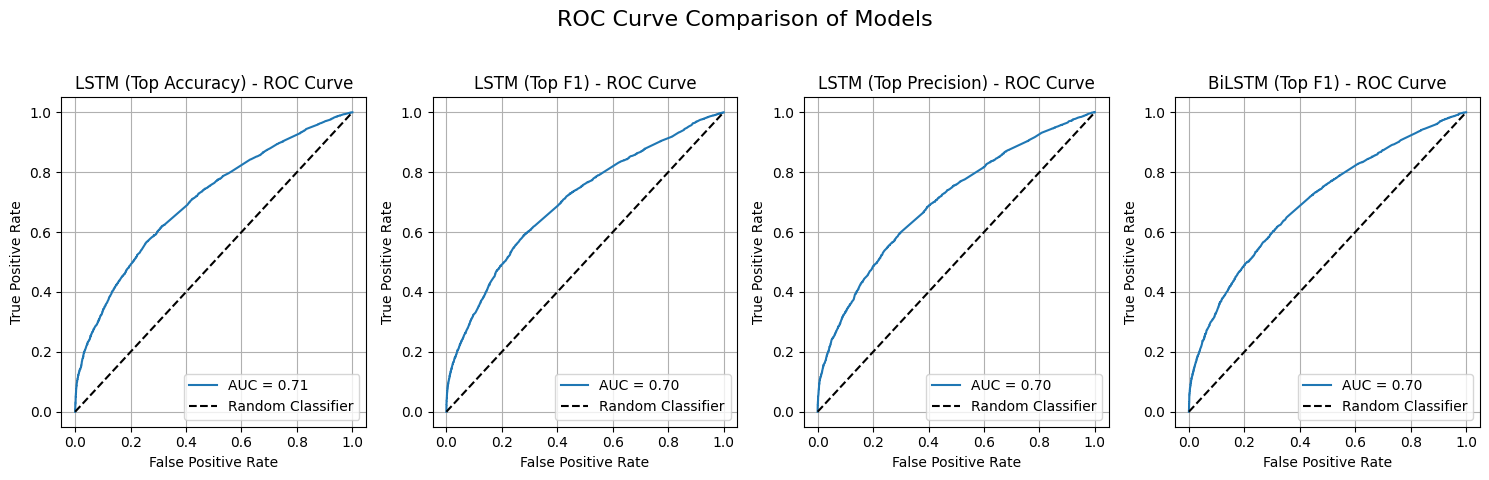

In [228]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, classification_report, precision_recall_curve

# ================== 1. LISTA DE MODELOS (ATUALIZE COM SEUS CAMINHOS!) ==================
model_paths = {
    "LSTM (Top Accuracy)": "modelo_IDS_lstm256_batch128_emb16_lr0001.keras",
    "LSTM (Top F1)": "modelo_IDS_lstm32_batch64_emb32_lr001.keras",
    "LSTM (Top Precision)": "modelo_IDS_lstm128_batch32_emb32_lr001.keras",
    "BiLSTM (Top F1)": "modelo_IDS_bilstm128_batch32_emb32_lr00025.keras",
    # "CNN+LSTM (Top Recall)": "modelo_IDS_cnnmultik_lstm64_batch256_emb32_lr00025.keras",
    # Adicione outros se quiser!
}

# ================== 2. CARREGAR DADOS (SUBSTITUA COM SEUS DADOS!) ==================
# X_test: dados de teste (shape [amostras, features])
# y_true: rótulos reais (0 = reliable, 1 = fake)
X_test = test_ids
y_true = y_test

# ================== 3. CALCULAR PROBABILIDADES E PLOTAR ROC ==================
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for ax, (model_name, path) in zip(axes, model_paths.items()):
    # Carregar modelo
    model = load_model(path)
    
    # Obter probabilidades da classe "fake" (1)
    y_probs = model.predict(X_test).flatten()  # Correto para saída única!
    
    # Calcular ROC e AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    # # Plotar curva ROC
    # RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name).plot()
    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    ax.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    ax.set_title(f"{model_name} - ROC Curve", fontsize=12)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)
    
    # (Opcional) Ajustar threshold para máximo F1-score
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_threshold = thresholds_pr[np.argmax(f1_scores)]
    
    # Gerar relatório com threshold ajustado
    y_pred_ajustado = (y_probs >= best_threshold).astype(int)
    print(f"\n🔍 {model_name} {path} - Relatório com Threshold Ajustado ({best_threshold:.4f}):")
    print(classification_report(y_true, y_pred_ajustado, target_names=["reliable", "fake"]))


plt.suptitle("ROC Curve Comparison of Models", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Linha de referência (modelo aleatório)
# plt.plot([0, 1], [0, 1], 'k--', label="Aleatório (AUC = 0.5)")
# plt.title('Comparação de Modelos - Curva ROC')
# plt.legend(loc="lower right")
# plt.show()

399/399 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step

🔍 LSTM - Relatório com Threshold Ajustado (0.2986):
              precision    recall  f1-score   support

    reliable       0.75      0.47      0.58      7339
        fake       0.52      0.79      0.63      5403

    accuracy                           0.60     12742
   macro avg       0.63      0.63      0.60     12742
weighted avg       0.65      0.60      0.60     12742

399/399 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step

🔍 BiLSTM - Relatório com Threshold Ajustado (0.3403):
              precision    recall  f1-score   support

    reliable       0.74      0.49      0.59      7339
        fake       0.53      0.77      0.62      5403

    accuracy                           0.61     12742
   macro avg       0.63      0.63      0.61     12742
weighted avg       0.65      0.61      0.60     12742



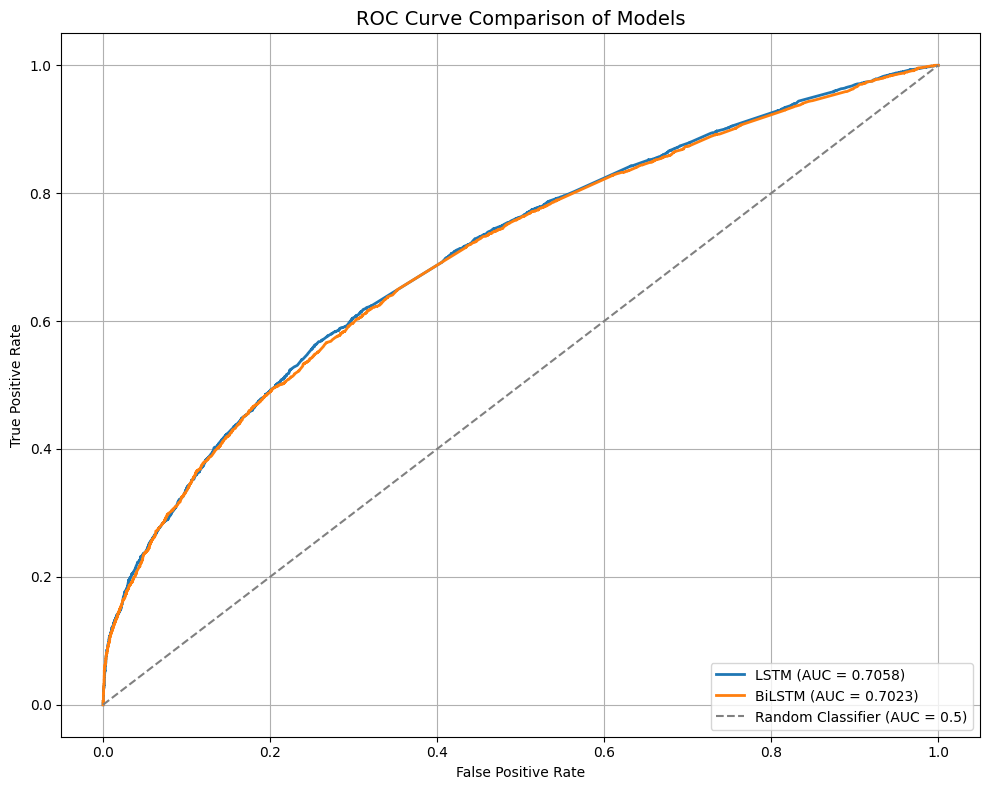

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve

# ========== MODELOS ==========
model_paths = {
    "LSTM": "modelo_IDS_lstm256_batch128_emb16_lr0001.keras",
    "BiLSTM": "modelo_IDS_bilstm128_batch32_emb32_lr00025.keras"
}

# ========== DADOS ==========
X_test = test_ids
y_true = y_test

# ========== PLOT ==========
plt.figure(figsize=(10, 8))

for model_name, path in model_paths.items():
    model = load_model(path)
    y_probs = model.predict(X_test).flatten()

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.4f})")

    # (Opcional) Threshold ideal para F1
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_threshold = thresholds_pr[np.argmax(f1_scores)]
    y_pred_ajustado = (y_probs >= best_threshold).astype(int)
    print(f"\n🔍 {model_name} - Relatório com Threshold Ajustado ({best_threshold:.4f}):")
    print(classification_report(y_true, y_pred_ajustado, target_names=["reliable", "fake"]))

# Linha aleatória
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier (AUC = 0.5)")

plt.title("ROC Curve Comparison of Models", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [212]:
# Supondo que você já escolheu o modelo "BiLSTM (Top F1)" com AUC=0.70
model = load_model("modelo_IDS_bilstm128_batch32_emb32_lr00025.keras")
y_probs = model.predict(X_test).flatten()

# Ajuste manual do threshold (ex.: priorizar precision)
y_pred_precision = (y_probs >= 0.5).astype(int)  # Threshold conservador
print(classification_report(y_test, y_pred_precision))

399/399 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step
              precision    recall  f1-score   support

         0.0       0.68      0.79      0.73      7339
         1.0       0.63      0.50      0.56      5403

    accuracy                           0.67     12742
   macro avg       0.66      0.64      0.64     12742
weighted avg       0.66      0.67      0.66     12742



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(10, 8))
# Plota ROC para LSTM
RocCurveDisplay(fpr=fpr_lstm, tpr=tpr_lstm, roc_auc=0.71, estimator_name="LSTM (AUC=0.71)").plot()
# Plota ROC para BiLSTM
RocCurveDisplay(fpr=fpr_bilstm, tpr=tpr_bilstm, roc_auc=0.70, estimator_name="BiLSTM (AUC=0.70)").plot()
# Plota ROC para CNN+LSTM
RocCurveDisplay(fpr=fpr_cnnlstm, tpr=tpr_cnnlstm, roc_auc=0.70, estimator_name="CNN+LSTM (AUC=0.70)").plot()

plt.plot([0, 1], [0, 1], 'k--', label="Aleatório (AUC=0.5)")
plt.title("Comparação de Modelos - Curvas ROC")
plt.legend()
plt.show()